In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import os

batch_size = 10

# Loading and normalizing the data.
# Define transformations for the training and test sets
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create an instance for training. 
train_set = torchvision.datasets.ImageFolder('fruits-360/Training', transform=preprocess)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)

# Create an instance for testing, note that train is set to False.
# When we run this code for the first time, the CIFAR10 test dataset will be downloaded locally. 
test_set = torchvision.datasets.ImageFolder('fruits-360/Test', transform=preprocess)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)

In [2]:
classes = []
for folder in os.listdir('fruits-360/Training'):
    classes.append(folder)
len(classes)

131

In [3]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

# Define a convolution neural network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(4)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(6)
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=8, kernel_size=5, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(8)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, stride=1, padding=0)
        self.bn4 = nn.BatchNorm2d(12)
        self.fc1 = nn.Linear(12*47*47, 8*45*45)
        self.fc2 = nn.Linear(8*45*45, len(classes))

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))      
        output = F.relu(self.bn2(self.conv2(output)))   
        output = F.relu(self.bn3(self.conv3(output))) 
        output = self.pool(output)                        
        output = F.relu(self.bn4(self.conv4(output)))       
        output = output.view(-1, 12*47*47)
        output = F.relu(self.fc1(output))
        output = torch.sigmoid(self.fc2(output))

        return output

# Instantiate a neural network model 
model = CNN()

In [4]:
from torch.optim import SGD
loss_fn = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.001, weight_decay=0.0001)

In [5]:
from torch.autograd import Variable

# Function to save the model
def saveModel():
    path = "./fruitModel2.pth"
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    
    best_accuracy = 0.0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value  
            # print every 1000 (twice per epoch) 
            if i % 1000 == 999:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy for this epoch when tested over all 10000 test images
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    device = torch.device("cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)
    # get batch of images from the test DataLoader  
    images, labels = next(iter(test_loader))
    images = Variable(images.to(device))
    labels = Variable(labels.to(device))
    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))
   
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(batch_size)))
  
    # Let's see what if the model identifiers the  labels of those example
    outputs = model(images)
    
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)
    
    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(batch_size)))

In [7]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
train(15)
print('Finished Training')
model = CNN()
path = "fruitModel2.pth"
model.load_state_dict(torch.load(path))


The model will be running on cuda:0 device
[1,  1000] loss: 4.727
[1,  2000] loss: 4.464
[1,  3000] loss: 4.314
[1,  4000] loss: 4.221
[1,  5000] loss: 4.167
[1,  6000] loss: 4.130
For epoch 1 the test accuracy over the whole test set is 59 %
[2,  1000] loss: 3.976
[2,  2000] loss: 3.949
[2,  3000] loss: 3.938
[2,  4000] loss: 3.929
[2,  5000] loss: 3.924
[2,  6000] loss: 3.919
For epoch 2 the test accuracy over the whole test set is 58 %
[3,  1000] loss: 3.913
[3,  2000] loss: 3.909
[3,  3000] loss: 3.908
[3,  4000] loss: 3.908
[3,  5000] loss: 3.906
[3,  6000] loss: 3.903
For epoch 3 the test accuracy over the whole test set is 75 %
[4,  1000] loss: 3.900
[4,  2000] loss: 3.899
[4,  3000] loss: 3.899
[4,  4000] loss: 3.901
[4,  5000] loss: 3.898
[4,  6000] loss: 3.899
For epoch 4 the test accuracy over the whole test set is 67 %
[5,  1000] loss: 3.896
[5,  2000] loss: 3.896
[5,  3000] loss: 3.895
[5,  4000] loss: 3.895
[5,  5000] loss: 3.896
[5,  6000] loss: 3.894
For epoch 5 the tes

<All keys matched successfully>

The model will be running on cpu device


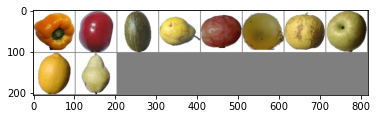

Real labels:  Pepper Yellow Cherry 2 Melon Piel de Sapo Pear Monster Grape Pink Grape White 3 Apple Golden 1 Apple Golden 3 Lemon Pear Williams
Predicted:  Pepper Yellow Cherry 2 Dates Cactus fruit Grape Pink Grape White 3 Apple Granny Smith Apple Granny Smith Lemon Pear Williams


In [8]:
testBatch()

In [25]:
def classifyImage(img: np.array) -> np.array:
    top_fruits = []
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)
    
    ySize = int((img.shape[0] - 99)/10)+1
    xSize = int((img.shape[1] - 99)/10)+1
    out = np.zeros(shape=(ySize, xSize))
    for r in range(ySize):
        for c in range(xSize):
            sub = img[r*10:r*10+100, c*10:c*10+100]
            with torch.no_grad():
                outputs = model(preprocess(sub).unsqueeze(0).to(device))
                val, predicted = torch.max(outputs, 1)
                out[r,c] = int(predicted.item()) if val.item() > 0.8 else -1
                if val.item() > 0.8:
                    top_fruits.append(classes[predicted.item()])
        if r%10==0:
            print("("+str(r)+"):",val.item(), predicted.item())
    return out, top_fruits;

(671, 1000, 3)

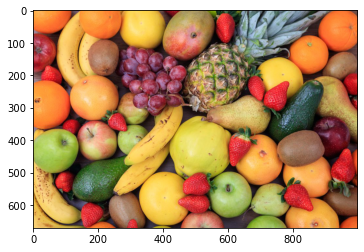

In [26]:
import imageio
import matplotlib.pyplot as plt 

img = imageio.imread('fruit_test_1.jpg')
plt.imshow(img)
img.shape


In [27]:
out, fruits = classifyImage(img)

The model will be running on cuda:0 device
(0): 0.41730672121047974 11
(10): 0.31439971923828125 99
(20): 0.307728111743927 56
(30): 0.5113619565963745 42
(40): 0.36096125841140747 17
(50): 0.23391903936862946 55


In [28]:
def maxpool(img: np.array, dim, stride) -> np.array:
    ySize = int((img.shape[0] - dim + 1)/stride)+1
    xSize = int((img.shape[1] - dim + 1)/stride)+1
    out = np.zeros(shape=(ySize, xSize))
    for r in range(ySize):
        for c in range(xSize):
            sub = img[r*stride:r*stride+dim, c*stride:c*stride+dim]
            out[r,c] = np.max(sub)
    return out;

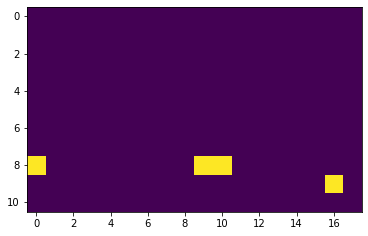

In [29]:
imOut = maxpool(out, 5, 5)
plt.imshow(imOut)

In [30]:
outlabels = []
for i in imOut:
    for j in i:
        if j != -1:
            outlabels.append(classes[int(j)])
outlabels

['Pear Abate', 'Pear Abate', 'Pear Abate', 'Pear Abate']

(800, 1200, 3)

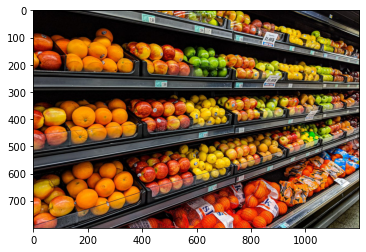

In [31]:
import imageio
import matplotlib.pyplot as plt 

img2 = imageio.imread('fruit_test_2.jpg')
plt.imshow(img2)
img2.shape

In [32]:
out2, fruits2 = classifyImage(img2)

The model will be running on cuda:0 device
(0): 0.27077266573905945 85
(10): 0.39138299226760864 21
(20): 0.23437878489494324 68
(30): 0.1849682629108429 55
(40): 0.28546181321144104 42
(50): 0.4455086588859558 11
(60): 0.3251662254333496 85
(70): 0.18707512319087982 99


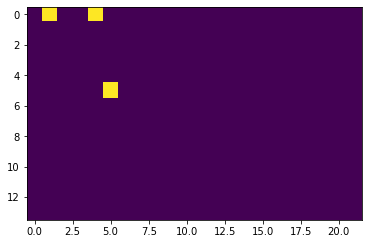

In [33]:
imOut2 = maxpool(out2, 5, 5)
plt.imshow(imOut2)

In [34]:
outlabels2 = []
for i in imOut2:
    for j in i:
        if j != -1:
            outlabels2.append(classes[int(j)])
outlabels2

['Pear Abate', 'Pear Abate', 'Pear Abate']

(706, 1000, 3)

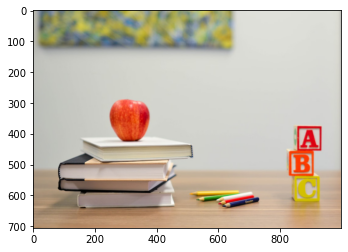

In [35]:
import imageio
import matplotlib.pyplot as plt 

img3 = imageio.imread('fruit_test_3.jpg')
plt.imshow(img3)
img3.shape

In [36]:
out3, fruits3 = classifyImage(img3)

The model will be running on cuda:0 device
(0): 0.4757475256919861 85
(10): 0.40974757075309753 16
(20): 0.41469770669937134 85
(30): 0.4198525547981262 85
(40): 0.34856387972831726 99
(50): 0.3864781856536865 86
(60): 0.3307373821735382 10


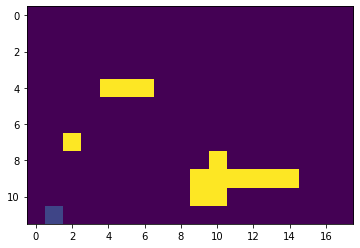

In [37]:
imOut3 = maxpool(out3, 5, 5)
plt.imshow(imOut3)

In [38]:
outlabels3 = []
for i in imOut3:
    for j in i:
        if j != -1:
            outlabels3.append(classes[int(j)])
outlabels3

['Pear Abate',
 'Pear Abate',
 'Pear Abate',
 'Pear Abate',
 'Pear Abate',
 'Pear Abate',
 'Pear Abate',
 'Pear Abate',
 'Pear Abate',
 'Pear Abate',
 'Pear Abate',
 'Pear Abate',
 'Pear Abate',
 'Banana Lady Finger']